In [80]:
import wandb

import pandas as pd
import numpy as np
import sklearn
import flwr
import xgboost as xgb
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

import missingno as mn

import platform
import sys
import subprocess
import psutil

In [81]:
print(f"Operating System: {platform.system()} {platform.release()}")
print(f"Python Version: {sys.version}")

print(f"Machine: {platform.machine()}")
print(f"Processor: {platform.processor()}")

ram = psutil.virtual_memory().total / (1024 ** 2)  # Bytes -> MB
print(f"RAM: {ram:.2f} MB")

print(f"Scikit-Learn Version: {sklearn.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"WandB Version: {wandb.__version__}")
print(f"Flower Version: {flwr.__version__}")
print(f"XGBoost Version: {xgb.__version__}")

Operating System: Darwin 24.2.0
Python Version: 3.9.21 | packaged by conda-forge | (main, Dec  5 2024, 13:47:18) 
[Clang 18.1.8 ]
Machine: arm64
Processor: arm
RAM: 16384.00 MB
Scikit-Learn Version: 1.6.1
NumPy Version: 2.0.2
Pandas Version: 2.2.3
WandB Version: 0.19.4
Flower Version: 1.14.0
XGBoost Version: 2.1.3


# Data Exploration and Preprocessing

In [34]:
columns = [
    'institute', 'age', 'workclass', 'education', 'education-num', 
    'marital-status', 'occupation', 'relationship', 'race', 
    'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 
    'native-country', 'income'
]

bankA_df = pd.read_csv("BankA.csv")
bankB_df = pd.read_csv("BankB.csv")
bankC_df = pd.read_csv("BankC.csv")

bankA_df.columns = columns
bankB_df.columns = columns
bankC_df.columns = columns

#print(bankA_df.info())
#print(bankB_df.info())
#print(bankC_df.info())


In [37]:
# Strip whitespace from string columns
for col in bankA_df.select_dtypes(include=['object']).columns:
    bankA_df[col] = bankA_df[col].str.strip()
    
for col in bankB_df.select_dtypes(include=['object']).columns:
    bankB_df[col] = bankB_df[col].str.strip()

for col in bankC_df.select_dtypes(include=['object']).columns:
    bankC_df[col] = bankC_df[col].str.strip()
    
# Encode target variable with explicit type conversion
bankA_df['income'] = pd.to_numeric(bankA_df['income'].replace({'<=50K': 0, '>50K': 1}), downcast='integer')
bankB_df['income'] = pd.to_numeric(bankB_df['income'].replace({'<=50K': 0, '>50K': 1}), downcast='integer')
bankC_df['income'] = pd.to_numeric(bankC_df['income'].replace({'<=50K': 0, '>50K': 1}), downcast='integer')


In [38]:
# Combine train and test datasets for preprocessing
# df_combined = pd.concat([data_train, data_test], ignore_index=True)
bankA_df.replace("?", np.nan, inplace=True)
print(f"Shape: {bankA_df.shape}")

bankB_df.replace("?", np.nan, inplace=True)
print(f"Shape: {bankB_df.shape}")

bankC_df.replace("?", np.nan, inplace=True)
print(f"Shape: {bankC_df.shape}")


Shape: (226456, 15)
Shape: (402923, 15)
Shape: (170620, 15)


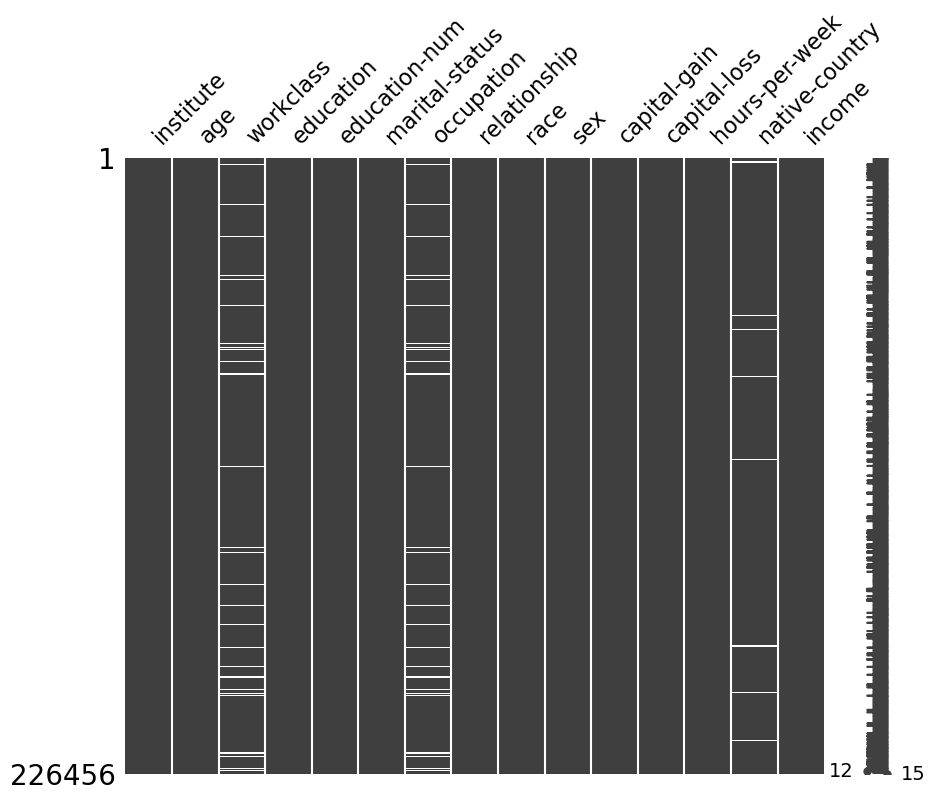

In [39]:
mn.matrix(bankA_df,figsize=(10,8));

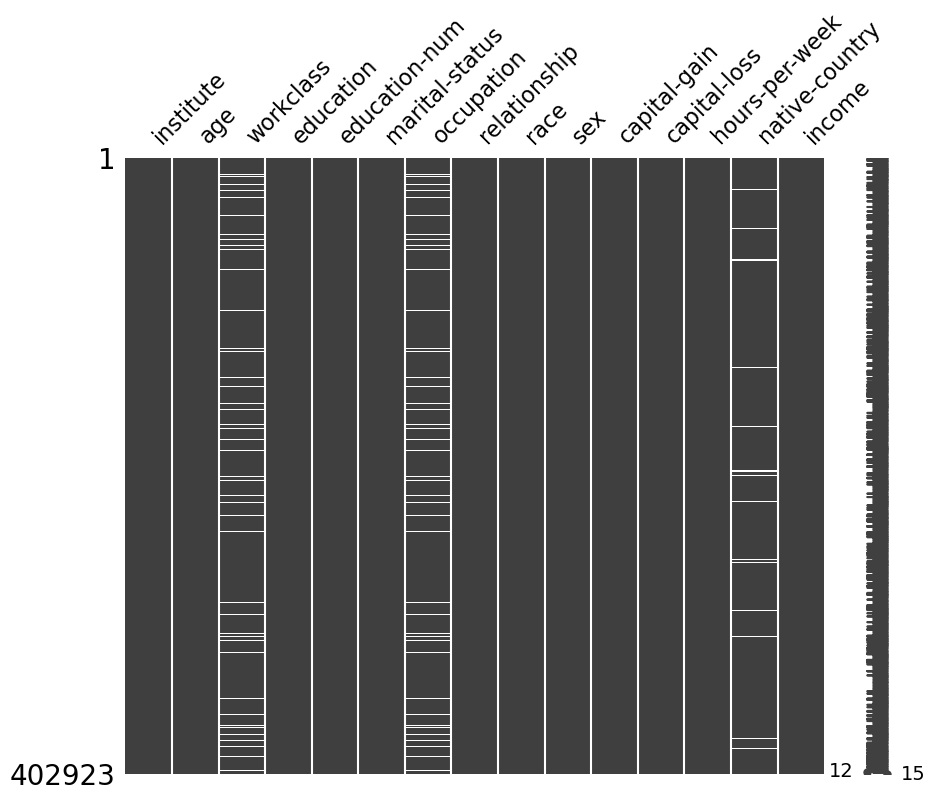

In [40]:
mn.matrix(bankB_df,figsize=(10,8));

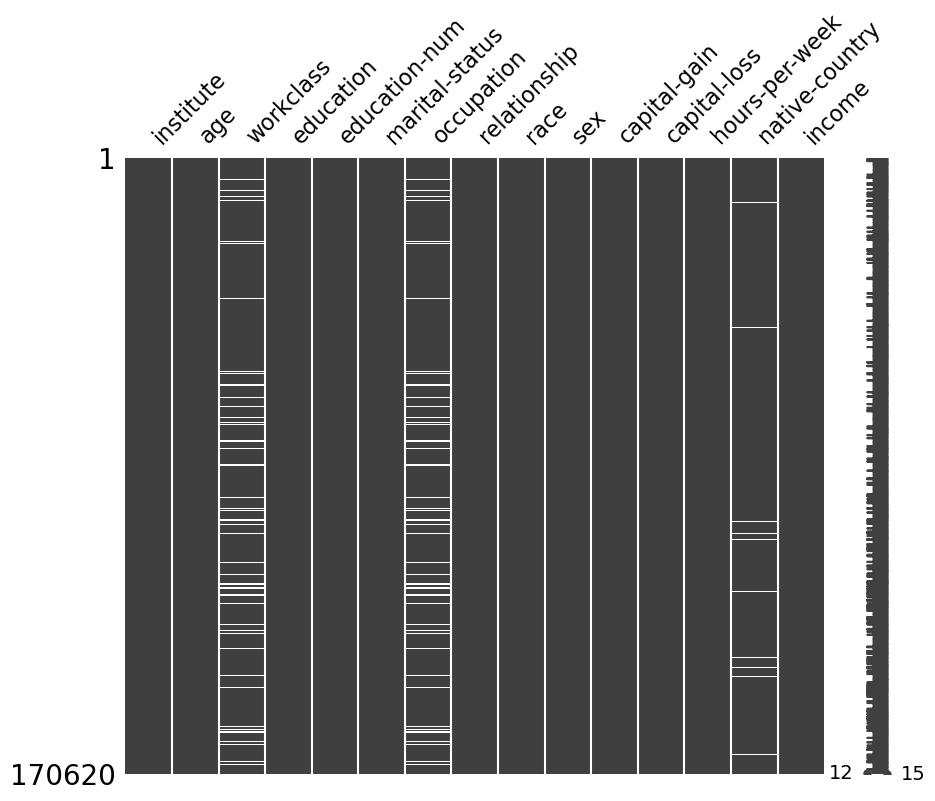

In [41]:
mn.matrix(bankC_df,figsize=(10,8));

In [46]:
# Identify categorical columns for future OHE and ordinal for scaling

categoricalA_columns = ['institute', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ordinalA_columns = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

categoricalB_columns = ['institute', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ordinalB_columns = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

categoricalC_columns = ['institute', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
ordinalC_columns = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


In [47]:
categoricalA_columns

['institute',
 'workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [48]:
ordinalA_columns

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [49]:
bankA_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226456 entries, 0 to 226455
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   institute       226456 non-null  object
 1   age             226456 non-null  int64 
 2   workclass       216378 non-null  object
 3   education       226456 non-null  object
 4   education-num   226456 non-null  int64 
 5   marital-status  226456 non-null  object
 6   occupation      216340 non-null  object
 7   relationship    226456 non-null  object
 8   race            226456 non-null  object
 9   sex             226456 non-null  object
 10  capital-gain    226456 non-null  int64 
 11  capital-loss    226456 non-null  int64 
 12  hours-per-week  226456 non-null  int64 
 13  native-country  221551 non-null  object
 14  income          226456 non-null  int8  
dtypes: int64(5), int8(1), object(9)
memory usage: 24.4+ MB


In [50]:
# Identify attributes with missing values 
nan_Acolumns = bankA_df.columns[bankA_df.isna().any()].tolist()
categoricalA_columns_without_nan = [i for i in categoricalA_columns if i not in nan_Acolumns]

nan_Bcolumns = bankB_df.columns[bankB_df.isna().any()].tolist()
categoricalB_columns_without_nan = [i for i in categoricalB_columns if i not in nan_Bcolumns]

nan_Ccolumns = bankC_df.columns[bankC_df.isna().any()].tolist()
categoricalC_columns_without_nan = [i for i in categoricalC_columns if i not in nan_Ccolumns]


In [51]:
nan_Acolumns

['workclass', 'occupation', 'native-country']

In [52]:
# OHE categrical attributes without missing values
bankA_df = pd.get_dummies(bankA_df, columns=categoricalA_columns_without_nan, drop_first=True)

bankB_df = pd.get_dummies(bankB_df, columns=categoricalB_columns_without_nan, drop_first=True)

bankC_df = pd.get_dummies(bankC_df, columns=categoricalC_columns_without_nan, drop_first=True)

In [53]:
bankA_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226456 entries, 0 to 226455
Data columns (total 40 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   age                                   226456 non-null  int64 
 1   workclass                             216378 non-null  object
 2   education-num                         226456 non-null  int64 
 3   occupation                            216340 non-null  object
 4   capital-gain                          226456 non-null  int64 
 5   capital-loss                          226456 non-null  int64 
 6   hours-per-week                        226456 non-null  int64 
 7   native-country                        221551 non-null  object
 8   income                                226456 non-null  int8  
 9   education_11th                        226456 non-null  bool  
 10  education_12th                        226456 non-null  bool  
 11  education_1st

In [54]:
bankA_df.head()

,age,workclass,education-num,occupation,capital-gain,capital-loss,hours-per-week,native-country,income,education_11th,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,39,Private,13,Exec-managerial,7298,0,50,United-States,1,False,...,False,False,False,False,False,False,False,False,True,True
1,42,Private,13,Tech-support,0,0,55,United-States,1,False,...,False,False,False,False,False,False,False,False,True,True
2,34,Self-emp-not-inc,14,Sales,0,0,45,United-States,1,False,...,False,False,False,False,False,False,False,False,True,True
3,74,Federal-gov,13,Prof-specialty,0,2217,38,United-States,1,False,...,False,False,False,False,False,False,False,False,True,True
4,48,Private,14,Exec-managerial,0,0,50,United-States,0,False,...,False,False,False,False,False,False,False,False,True,True


In [55]:
# Label encode categorical attributes with missing values to prepare for imputation
le_decodeA = {}
for column in nan_Acolumns:
    leA = LabelEncoder()
    leA.fit(bankA_df[column])
    bankA_df[column] = leA.transform(bankA_df[column])
    le_decodeA[column] = leA

    # Transform missing values back to NaN after label encoding
    if np.nan in list(leA.classes_):
        nan_Alabel = list(leA.classes_).index(np.nan)
    bankA_df[column] = bankA_df[column].replace(nan_Alabel, np.nan)
 

In [56]:
le_decodeB = {}
for column in nan_Bcolumns:
    leB = LabelEncoder()
    leB.fit(bankB_df[column])
    bankB_df[column] = leB.transform(bankB_df[column])
    le_decodeB[column] = leB

    # Transform missing values back to NaN after label encoding
    if np.nan in list(leB.classes_):
        nan_Blabel = list(leB.classes_).index(np.nan)
    bankB_df[column] = bankB_df[column].replace(nan_Blabel, np.nan)

In [57]:
le_decodeC = {}
for column in nan_Ccolumns:
    leC = LabelEncoder()
    leC.fit(bankC_df[column])
    bankC_df[column] = leC.transform(bankC_df[column])
    le_decodeC[column] = leC

    # Transform missing values back to NaN after label encoding
    if np.nan in list(leC.classes_):
        nan_Clabel = list(leC.classes_).index(np.nan)
    bankC_df[column] = bankC_df[column].replace(nan_Clabel, np.nan)

In [58]:
def impute_nan_mode_multiple(df, columns):
    for column in columns:
        mode = df[column].mode()[0]
        df[column] = df[column].fillna(mode)
    return df

columns_to_impute = ['workclass', 'occupation', 'native-country']
df_imputedA = impute_nan_mode_multiple(bankA_df, columns_to_impute)

columns_to_impute = ['workclass', 'occupation', 'native-country']
df_imputedB = impute_nan_mode_multiple(bankB_df, columns_to_impute)

columns_to_impute = ['workclass', 'occupation', 'native-country']
df_imputedC = impute_nan_mode_multiple(bankC_df, columns_to_impute)

In [59]:
nan_Acolumns

['workclass', 'occupation', 'native-country']

In [60]:
# Transform label-encoded attributes with imputed values back to the original categorical values
for column in nan_Acolumns:
    df_imputedA[column] = le_decodeA[column].inverse_transform(df_imputedA[column].astype('int32'))

# OHE the attributes with categorical data and missing values which were imputed
df_combinedA_encoded = pd.get_dummies(df_imputedA, columns=nan_Acolumns, drop_first=True)

In [61]:
df_combinedA_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226456 entries, 0 to 226455
Data columns (total 97 columns):
 #   Column                                     Non-Null Count   Dtype
---  ------                                     --------------   -----
 0   age                                        226456 non-null  int64
 1   education-num                              226456 non-null  int64
 2   capital-gain                               226456 non-null  int64
 3   capital-loss                               226456 non-null  int64
 4   hours-per-week                             226456 non-null  int64
 5   income                                     226456 non-null  int8 
 6   education_11th                             226456 non-null  bool 
 7   education_12th                             226456 non-null  bool 
 8   education_1st-4th                          226456 non-null  bool 
 9   education_5th-6th                          226456 non-null  bool 
 10  education_7th-8th               

In [62]:
# Transform label-encoded attributes with imputed values back to the original categorical values
for column in nan_Bcolumns:
    df_imputedB[column] = le_decodeB[column].inverse_transform(df_imputedB[column].astype('int32'))

# OHE the attributes with categorical data and missing values which were imputed
df_combinedB_encoded = pd.get_dummies(df_imputedB, columns=nan_Bcolumns, drop_first=True)
# Convert income into 
df_combinedA_encoded['income'] = df_combinedA_encoded['income'].map({'>50K': 1, '<=50K': 0})


In [63]:
# Transform label-encoded attributes with imputed values back to the original categorical values
for column in nan_Ccolumns:
    df_imputedC[column] = le_decodeC[column].inverse_transform(df_imputedC[column].astype('int32'))

# OHE the attributes with categorical data and missing values which were imputed
df_combinedC_encoded = pd.get_dummies(df_imputedC, columns=nan_Ccolumns, drop_first=True)

In [64]:
df_combinedC_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170620 entries, 0 to 170619
Data columns (total 97 columns):
 #   Column                                     Non-Null Count   Dtype
---  ------                                     --------------   -----
 0   age                                        170620 non-null  int64
 1   education-num                              170620 non-null  int64
 2   capital-gain                               170620 non-null  int64
 3   capital-loss                               170620 non-null  int64
 4   hours-per-week                             170620 non-null  int64
 5   income                                     170620 non-null  int8 
 6   education_11th                             170620 non-null  bool 
 7   education_12th                             170620 non-null  bool 
 8   education_1st-4th                          170620 non-null  bool 
 9   education_5th-6th                          170620 non-null  bool 
 10  education_7th-8th               

In [65]:
# Scale ordinal attributes
df_combinedA_encoded [ordinalA_columns] = StandardScaler().fit_transform(df_combinedA_encoded [ordinalA_columns])
df_combinedA_encoded = df_combinedA_encoded.astype(float) # set the values of the presprocessed dataset to one type
df_combinedA_encoded.shape

(226456, 97)

In [66]:
# Scale ordinal attributes
df_combinedB_encoded [ordinalB_columns] = StandardScaler().fit_transform(df_combinedB_encoded [ordinalB_columns])
df_combinedB_encoded = df_combinedB_encoded.astype(float) # set the values of the presprocessed dataset to one type
df_combinedB_encoded.shape

(402923, 97)

In [67]:
# Scale ordinal attributes
df_combinedC_encoded [ordinalC_columns] = StandardScaler().fit_transform(df_combinedC_encoded [ordinalC_columns])
df_combinedC_encoded = df_combinedC_encoded.astype(float) # set the values of the presprocessed dataset to one type
df_combinedC_encoded.shape

(170620, 97)

In [68]:
df_combinedA_encoded.to_csv('BankA_Clean.csv', index=False)

df_combinedB_encoded.to_csv('BankB_Clean.csv', index=False)

df_combinedC_encoded.to_csv('BankC_Clean.csv', index=False)
